### 📚 Import Libraries


In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3


### 🗂️ Set Dataset Path & Classes


In [14]:
data_path = '/BrainTumorDataset/'  # ضع مسار مجلد الداتا
classes = ['no', 'yes']
images = []
labels = []


### 📂 Load Images & Labels


In [17]:
for idx, cls in enumerate(classes):
    cls_path = os.path.join(data_path, cls)
    for file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(idx)

### 🎨 Show Sample Images from Each Class


C:\Users\E_Magic\.conda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\E_Magic\.conda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


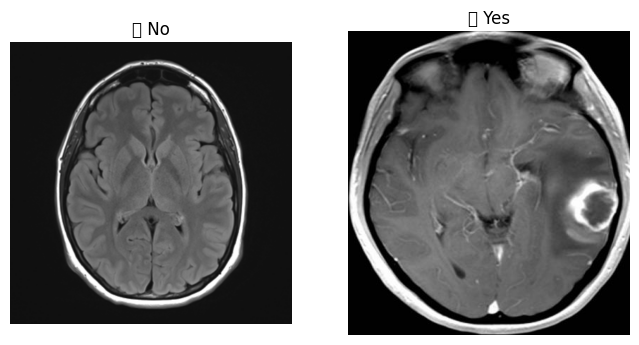

In [50]:
plt.figure(figsize=(8, 4))
for idx, dir in enumerate(classes, 1):
    files = list(os.listdir(os.path.join(data_path, dir)))
    img_file = random.choice(files)
    img_path = os.path.join(data_path, dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    emoji = "✅" if dir.lower() == 'yes' else "❌"
    plt.subplot(1, 2, idx)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{emoji} {dir.capitalize()}")
plt.show()


### 🔢 Convert to Numpy & Adjust Channels


In [18]:
images = np.array(images, dtype=np.float32)


In [19]:
if images.shape[-1] != 3:
    images = np.expand_dims(images, axis=-1)  # (num_samples, 224, 224, 1)
    images = np.concatenate([images]*3, axis=-1)  # (num_samples, 224, 224, 3)

labels = to_categorical(labels, num_classes=2)


### 📊 Split Data


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.15, random_state=42, stratify=labels
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (215, 224, 224, 3) (215, 2)
Testing set shape: (38, 224, 224, 3) (38, 2)


### 🌸 Data Augmentation


In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(X_train)


### 🧠 Build ResNet50 Model


In [23]:
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
resnet_base = ResNet50(weights=None, include_top=False, input_tensor=inputs)
x = Flatten()(resnet_base.output)
outputs = Dense(2, activation='softmax')(x)
resnet_model = Model(inputs, outputs)
resnet_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,788,418 (90.75 MB)

 Trainable params: 23,735,298 (90.54 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 🧠 Build EfficientNetB0 Model


In [24]:
inputs = Input(shape=input_shape)
efficient_base = EfficientNetB0(weights=None, include_top=False, input_tensor=inputs)
x = Flatten()(efficient_base.output)
outputs = Dense(2, activation='softmax')(x)
efficient_model = Model(inputs, outputs)
efficient_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
efficient_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_excite (Multiply)  │ (None, 112, 112, 32)      │               0 │ block1a_activation[0][0],  │
│                               │                           │               

 Total params: 4,175,013 (15.93 MB)

 Trainable params: 4,132,990 (15.77 MB)

 Non-trainable params: 42,023 (164.16 KB)

### 🧠 Build InceptionV3 Model


In [25]:
inputs = Input(shape=input_shape)
inception_base = InceptionV3(weights=None, include_top=False, input_tensor=inputs)
x = Flatten()(inception_base.output)
outputs = Dense(2, activation='softmax')(x)
inception_model = Model(inputs, outputs)
inception_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,905,186 (83.56 MB)

 Trainable params: 21,870,754 (83.43 MB)

 Non-trainable params: 34,432 (134.50 KB)

### 🎯 Train EfficientNetB0 with Augmentation


In [26]:
history_efficient = efficient_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=15
)

C:\Users\E_Magic\.conda\envs\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5721 - loss: 0.9984 - val_accuracy: 0.3947 - val_loss: 0.6934
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6000 - loss: 0.7766 - val_accuracy: 0.6053 - val_loss: 0.6878
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6372 - loss: 0.6894 - val_accuracy: 0.6053 - val_loss: 0.6741
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6326 - loss: 0.6932 - val_accuracy: 0.6053 - val_loss: 0.6869
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7116 - loss: 0.7655 - val_accuracy: 0.6053 - val_loss: 0.6727
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6465 - loss: 0.7393 - val_accuracy: 0.6053 - val_loss: 0.6747
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6791 - loss: 0.6893 - val_accuracy: 0.6053 - val_loss: 0.6726
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6279 - loss: 0.7566 - val_accuracy: 0.6053 - val_loss:

### 🎯 Train ResNet50 with Augmentation


In [28]:
history_resnet = resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=15
)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 121s 6s/step - accuracy: 0.5860 - loss: 3.7567 - val_accuracy: 0.7895 - val_loss: 0.5359
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.5814 - loss: 1.9514 - val_accuracy: 0.7105 - val_loss: 0.5780
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.5953 - loss: 1.4291 - val_accuracy: 0.6316 - val_loss: 0.6167
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.6744 - loss: 1.6258 - val_accuracy: 0.6053 - val_loss: 0.6732
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.6512 - loss: 1.2279 - val_accuracy: 0.7632 - val_loss: 0.6665
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.6326 - loss: 1.6572 - val_accuracy: 0.3684 - val_loss: 0.7225
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6372 - loss: 1.9080 - val_accuracy: 0.6053 - val_loss: 0.7947
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6465 - loss: 2.3519 - val_accuracy: 0.3947 - val_loss

### 🎯 Train InceptionV3 with Augmentation


In [29]:
history_inception = inception_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=15
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.6000 - loss: 1.0095 - val_accuracy: 0.6053 - val_loss: 0.6830
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7116 - loss: 0.7117 - val_accuracy: 0.6053 - val_loss: 0.6779
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6837 - loss: 0.7139 - val_accuracy: 0.6053 - val_loss: 0.6716
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6977 - loss: 0.7402 - val_accuracy: 0.6053 - val_loss: 0.6932
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6651 - loss: 1.0082 - val_accuracy: 0.6053 - val_loss: 0.6773
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7349 - loss: 0.7806 - val_accuracy: 0.3947 - val_loss: 0.7326
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7581 - loss: 0.6880 - val_accuracy: 0.6053 - val_loss: 0.6885
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7628 - loss: 0.7151 - val_accuracy: 0.3947 - val_loss:

### 📊 Plot Accuracy & Loss Curves


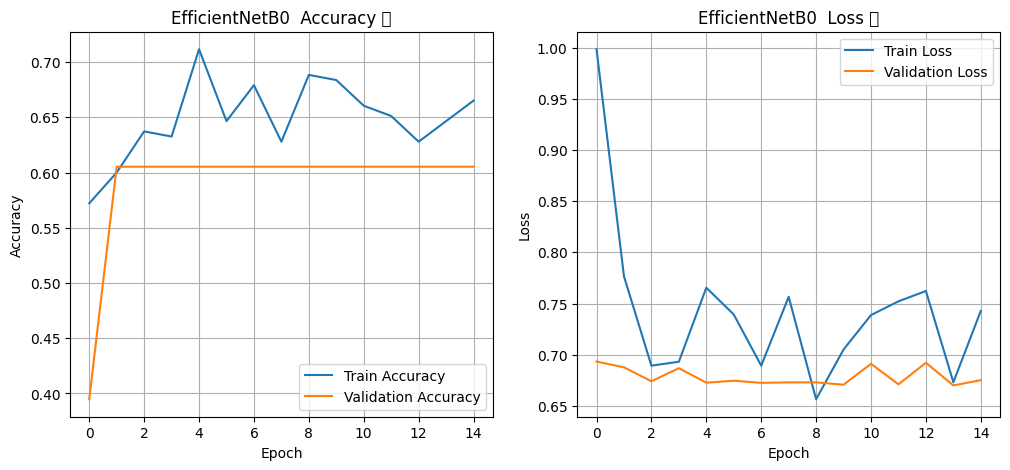

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_efficient.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0  Accuracy 🚀')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_efficient.history['loss'], label='Train Loss')
plt.plot(history_efficient.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0  Loss 🔥')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 💾 Save Models in Keras  Format


In [52]:
efficient_model.save("efficient_tumor_model.keras")
resnet_model.save("resnet_tumor_model.keras.keras")


In [46]:
def prepare_image(image_path, target_size=(224,224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [47]:
def predict_image(model, image_path):
    img = prepare_image(image_path)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    classes = {0: "No Tumor ❌", 1: "Tumor ✅"}
    return classes[class_idx], pred

In [48]:
result, prob = predict_image(efficient_model, "D:/Asmaa/tum.png")
print("Predicted class:", result)
print("Class probabilities:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Tumor ✅
Class probabilities: [[0.34374768 0.6562523 ]]


In [49]:
result, prob = predict_image(efficient_model, r"D:\Asmaa\tum2.jpg")
print("Predicted class:", result)
print("Class probabilities:", prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicted class: Tumor ✅
Class probabilities: [[0.34373677 0.65626323]]


##  ✂️-Segmentation

Part_2>>>>>>>>>>>>>>>>>>>>>>>>>>>